# Convolutional Neural Networks

Up until transformers, convolutions were *the* state of the art in computer vision.  In many ways and applications they still are!

Large Language Models, which are what we'll focus on the rest of the series after this lecture, are really good at ordered, *tokenized data.  But there is lots of data that isn't _implicitly_ ordered like `images`, and their more general cousins `graphs`.

Today's lecture focuses on computer vision models, and particularly on convolutional neural networks.  There are a ton of applications you can do with these, and not nearly enough time to get into them.  Check out the extra references file to see some publications to get you started if you want to learn more.


## Convolutional Networks: A brief historical context

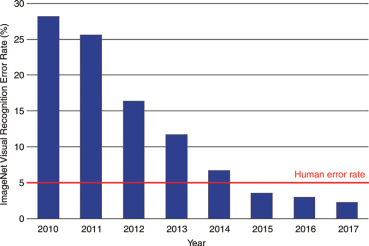

[reference](https://www.researchgate.net/publication/332452649_A_Roadmap_for_Foundational_Research_on_Artificial_Intelligence_in_Medical_Imaging_From_the_2018_NIHRSNAACRThe_Academy_Workshop)

In [1]:
import torch, torchvision

# Convolutional Building Blocks

## Convolutions

Convolutions are a restriction of - and a specialization of - dense linear layers.  A convolution of an image produces another image, and each output pixel is a function of only it's local neighborhood of points.  This is called an _inductive bias_ and is a big reason why convolutions work for image data: neighboring pixels are correlated and you can operate on just those pixels at a time.

See examples of convolutions [here](https://github.com/vdumoulin/conv_arithmetic)

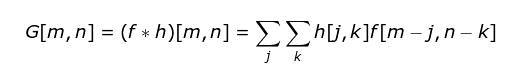

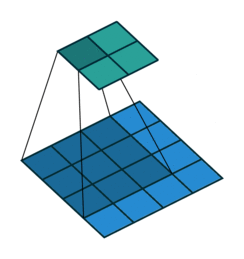

## Normalization

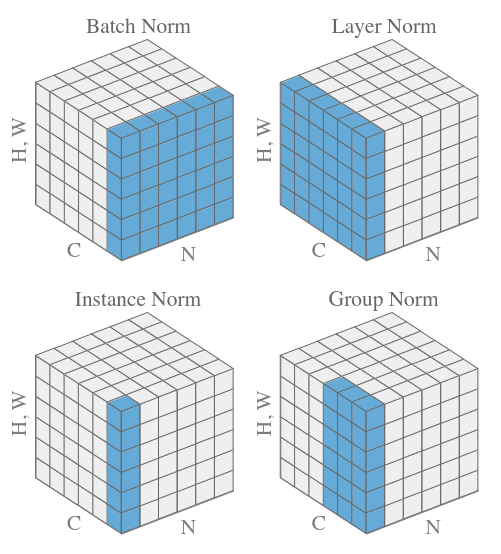
Reference: [Normalizations](https://arxiv.org/pdf/1903.10520.pdf)

Normalization is the act of transforming the mean and moment of your data to standard values (usually 0.0 and 1.0).  It's particularly useful in machine learning since it stabilizes training, and allows higher learning rates.

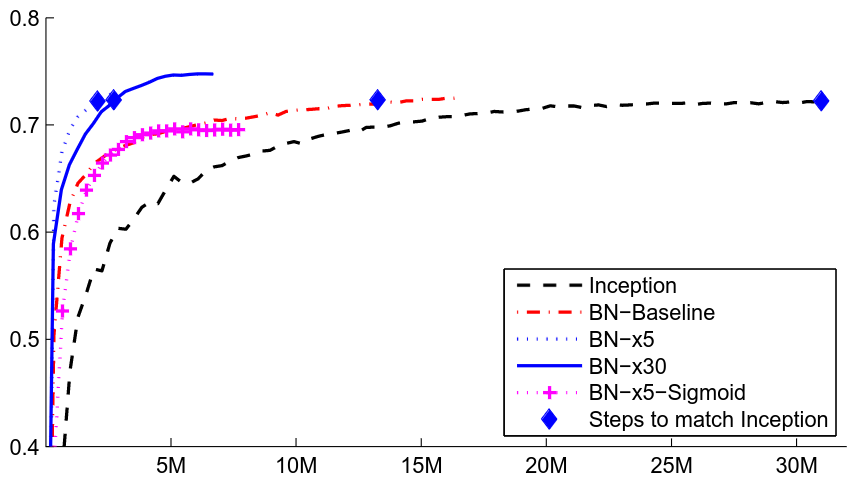

Reference: [Batch Norm](https://arxiv.org/pdf/1502.03167.pdf)

## Downsampling (And upsampling)

Downsampling is a critical component of convolutional and many vision models.  Because of the local-only nature of convolutional filters, learning large-range features can be too slow for convergence.  Downsampling of layers can bring information from far away closer, effectively changing what it means to be "local" as the input to a convolution.

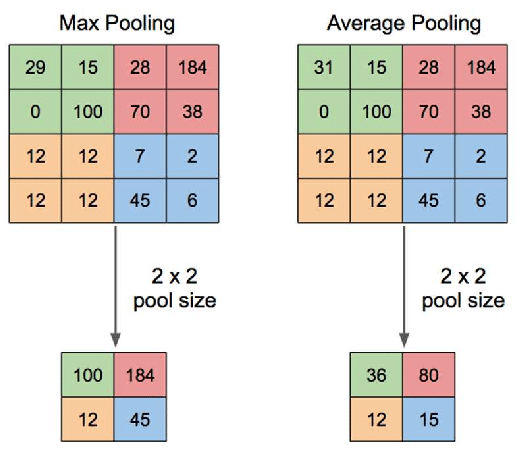

[Reference](https://www.researchgate.net/publication/333593451_Application_of_Transfer_Learning_Using_Convolutional_Neural_Network_Method_for_Early_Detection_of_Terry's_Nail)



# Building a ConvNet

In this section we'll build and apply a conv net to the mnist dataset.  The layers here are loosely based off of the ConvNext architecture.  Why?  Because we're getting into LLM's soon, and this ConvNet uses LLM features.

The dataset here is CIFAR-10 - slightly harder than MNIST but still relatively easy and computationally tractable.

In [12]:
training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [13]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [14]:
from torch import nn

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        # Two more convolutions:
        self.conv2 = torch.nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1)

        self.conv3 = torch.nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = nn.functional.layer_norm(x, x.shape)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self):
        super(Classifier, self).__init__()


        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = torch.nn.Conv2d(in_channels=3,
                                    out_channels=32,
                                    kernel_size=4,
                                    stride=4)
        
        # Apply a series of convolutional blocks:
        self.conv_block_1 = torch.nn.Sequential(
            ConvNextBlock(in_channels = 32,),
            ConvNextBlock(in_channels = 32,),
            ConvNextBlock(in_channels = 32,),
            ConvNextBlock(in_channels = 32,),
            ConvNextBlock(in_channels = 32,)
        )

        # Downsample the outputs:
        self.downsample = torch.nn.Conv2d(in_channels=32, out_channels=64, 
                                          kernel_size=2, stride=2)

        # Apply another series of convolutional blocks:
        self.conv_block_2 = torch.nn.Sequential(
            ConvNextBlock(in_channels = 64,),
            ConvNextBlock(in_channels = 64,),
            ConvNextBlock(in_channels = 64,),
            ConvNextBlock(in_channels = 64,),
            ConvNextBlock(in_channels = 64,)
        )

        # This brings it down to one channel / class
        self.bottleneck = torch.nn.Conv2d(in_channels=64, out_channels=10, 
                                          kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = torch.nn.functional.layer_norm(x, x.shape)

        x = self.conv_block_1(x)

        # Apply a normalization before downsampling:
        x = torch.nn.functional.layer_norm(x, x.shape)
        x = self.downsample(x)

        x = self.conv_block_2(x)


        x = self.bottleneck(x)

        # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [15]:
model = Classifier()

model.cuda()

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 8, 8]           1,568
├─Sequential: 1-2                        [128, 32, 8, 8]           --
│    └─ConvNextBlock: 2-1                [128, 32, 8, 8]           --
│    │    └─Conv2d: 3-1                  [128, 128, 8, 8]          6,400
│    │    └─Conv2d: 3-2                  [128, 32, 8, 8]           4,128
│    │    └─Conv2d: 3-3                  [128, 32, 8, 8]           1,056
│    └─ConvNextBlock: 2-2                [128, 32, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 128, 8, 8]          6,400
│    │    └─Conv2d: 3-5                  [128, 32, 8, 8]           4,128
│    │    └─Conv2d: 3-6                  [128, 32, 8, 8]           1,056
│    └─ConvNextBlock: 2-3                [128, 32, 8, 8]           --
│    │    └─Conv2d: 3-7                  [128, 128, 8, 8]       

In [16]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [17]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [18]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [19]:
%%time

epochs = 5
for j in range(epochs):
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, model, loss_fn)
    print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
    acc_val, loss_val = evaluate(val_dataloader, model, loss_fn)
    print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Epoch 0: training loss: 1.475, accuracy: 46.181
Validation loss: 1.4823, validation accuracy: 45.35%
Epoch 1: training loss: 1.239, accuracy: 55.242
Validation loss: 1.2902, validation accuracy: 52.76%
Epoch 2: training loss: 1.079, accuracy: 61.289
Validation loss: 1.2067, validation accuracy: 55.99%
Epoch 3: training loss: 0.985, accuracy: 64.791
Validation loss: 1.1876, validation accuracy: 57.08%
Epoch 4: training loss: 0.814, accuracy: 71.146
Validation loss: 1.1309, validation accuracy: 59.73%
CPU times: user 1min 57s, sys: 132 ms, total: 1min 57s
Wall time: 1min 54s


# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model - with only 200k parameters - on such a small dataset.  In the second notebook we'll look at addressing that.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer

And compare your final validation accuracy to the accuracy shown here.